In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice, product
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering, Birch

import warnings
warnings.filterwarnings('ignore')

выберем датасет

In [112]:
dataset = pd.read_csv('seattle-weather.csv')
dataset.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


убедимся в отсутствии пропусков

In [113]:
dataset.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

пусть значения наших колонок будет числовыми

In [114]:
le = LabelEncoder()
dataset['weather'] = le.fit_transform(dataset['weather'])
dataset = dataset.drop(columns=['date'])

Выберем подмножество признаков датасета для анализа. Полученный датасет назовем датасетом D1.

In [115]:
dataset_copy = dataset.copy()
D1 = pd.DataFrame(data=dataset, columns=['precipitation','temp_max','temp_min','wind'])
D1

,precipitation,temp_max,temp_min,wind
0,0.0,12.8,5.0,4.7
1,10.9,10.6,2.8,4.5
2,0.8,11.7,7.2,2.3
3,20.3,12.2,5.6,4.7
4,1.3,8.9,2.8,6.1
...,...,...,...,...
1456,8.6,4.4,1.7,2.9
1457,1.5,5.0,1.7,1.3
1458,0.0,7.2,0.6,2.6
1459,0.0,5.6,-1.0,3.4


С использованием метода главных компонент проведите для датасета D1 снижение размерности данных до двух. Полученный датасет назовем датасетом D2.

In [116]:
pca = PCA(n_components=2)
D2 = pca.fit_transform(D1)
print('Доля объясненной дисперсии: {}, сумма = {}'.format(pca.explained_variance_ratio_, 
                                                          np.sum(pca.explained_variance_ratio_)))

Доля объясненной дисперсии: [0.62359682 0.33166783], сумма = 0.9552646536187743


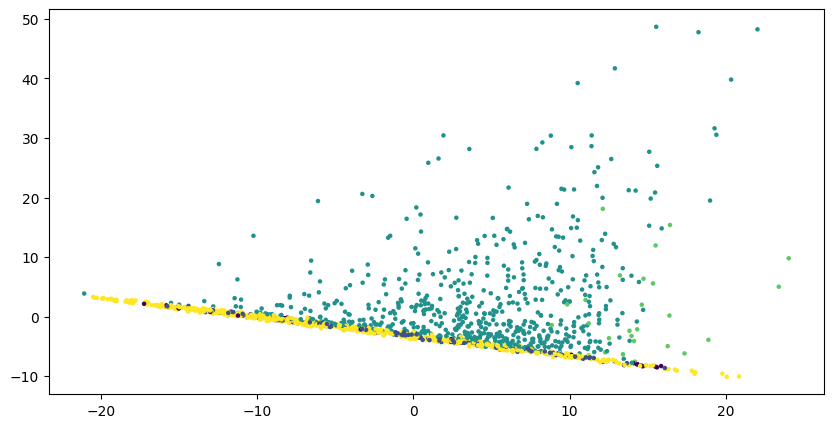

In [117]:
y = dataset['weather']
y
plt.figure(figsize=(10,5))
plt.scatter(D2[:, 0], D2[:, 1], s=5, c=y)
plt.show()

С использованием алгоритма t-SNE также проведите для датасета D1 снижение размерности данных до двух. Полученный датасет назовем датасетом D3.

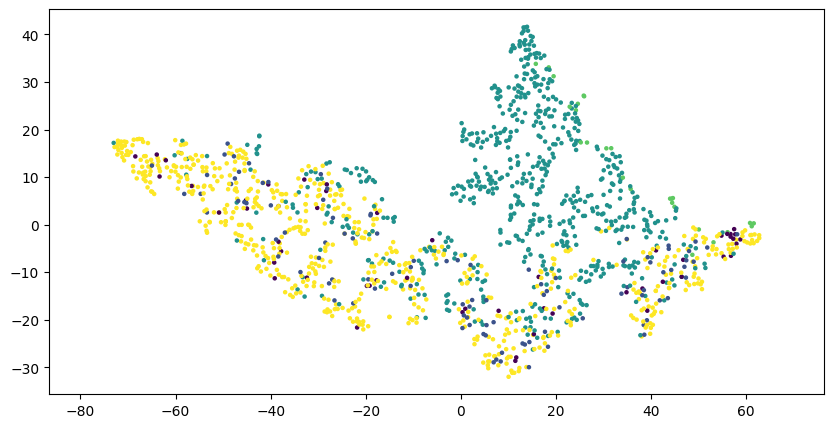

In [118]:
tsne = TSNE(n_components=2, random_state=16)
D3 = tsne.fit_transform(D1)
plt.figure(figsize=(10,5))
plt.scatter(D3[:, 0], D3[:, 1], s=5, c=y)
plt.axis('equal')
plt.show()


оценим качество кластеризации

метод k-средних

In [119]:
def do_clustering(cluster_datasets, method):
    """
    Выполнение кластеризации для данных примера
    """
    cluster_results = []
    for X in cluster_datasets:
        temp_cluster = method.fit_predict(X)
        cluster_results.append(temp_cluster)
    return cluster_results

In [131]:
def visualize_clusters(cluster_datasets, cluster_results):
    """
    Визуализация результатов кластерного анализа
    """
    plt.subplots(figsize=(16,8))
    plot_num = 0
    for X, y_pred in zip(cluster_datasets, cluster_results):
        plot_num += 1
        plt.subplot(2, 3, plot_num)
        # Цвета точек как результат кластеризации
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # черный цвет для выделяющихся значений
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=3, color=colors[y_pred])
#         plt.xlim(-2.5, 2.5)
#         plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.title(datasets_names[plot_num-1])
    
    plt.show()

In [121]:
cluster_datasets = [D2, D3]
cluster_datasetD1 = [D1]
datasets_names = ['D2', 'D3']

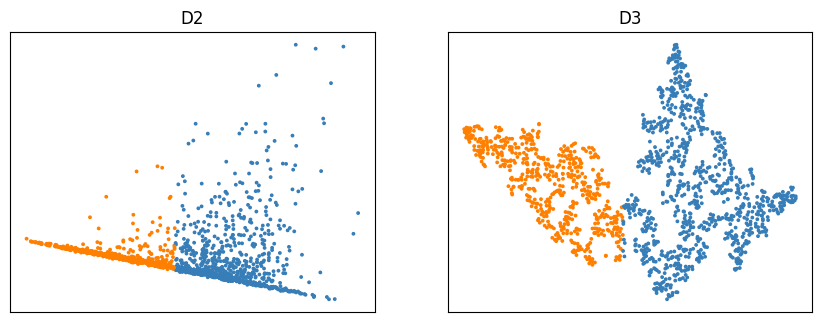

In [122]:
result_KMeans1 = do_clustering(cluster_datasetD1, KMeans(n_clusters=2))
result_KMeans23 = do_clustering(cluster_datasets, KMeans(n_clusters=2))
visualize_clusters(cluster_datasets, result_KMeans23)

In [123]:
print('Adjusted rand score:')
print('D1: ', adjusted_rand_score(y, result_KMeans1[0]))
print('D2: ', adjusted_rand_score(y, result_KMeans23[0]))
print('D3: ', adjusted_rand_score(y, result_KMeans23[1]))

Adjusted rand score:
D1:  0.15169124353925223
D2:  0.15276458771761364
D3:  0.19169683030571927


In [124]:
# Homogeneity - каждый кластер содержит только представителей единственного класса (под классом понимается истинное значение метки кластера). Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
# Completeness - все элементы одного класса помещены в один и тот же кластер. Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
# V-measure - среднее гармоническое от Homogeneity и Completeness.
h1, c1, v1 = homogeneity_completeness_v_measure(y, result_KMeans1[0])
h2, c2, v2 = homogeneity_completeness_v_measure(y, result_KMeans23[0])
h3, c3, v3 = homogeneity_completeness_v_measure(y, result_KMeans23[1])
print('Homogenity:')
print('D1: ', h1)
print('D2: ', h2)
print('D3: ', h3)
print('Completeness:')
print('D1: ', c1)
print('D2: ', c2)
print('D3: ', c3)
print('V-measure:')
print('D1: ', v1)
print('D2: ', v2)
print('D3: ', v3)

Homogenity:
D1:  0.09367287170249099
D2:  0.09425954363910158
D3:  0.12111027902596505
Completeness:
D1:  0.1501426990105722
D2:  0.15104739643979698
D3:  0.19887386426766154
V-measure:
D1:  0.11536833140189197
D2:  0.11608035754480027
D3:  0.15054289218529615


оценка методом Гауса

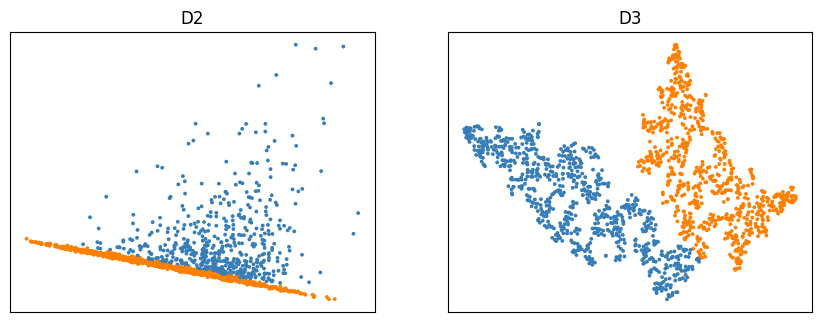

In [125]:
result_GaussianMixture1 = do_clustering(cluster_datasetD1, GaussianMixture(n_components=2))
result_GaussianMixture23 = do_clustering(cluster_datasets, GaussianMixture(n_components=2))
visualize_clusters(cluster_datasets, result_GaussianMixture23)

In [126]:
print('Adjusted rand score:')
print('D1: ', adjusted_rand_score(y, result_GaussianMixture1[0]))
print('D2: ', adjusted_rand_score(y, result_GaussianMixture23[0]))
print('D3: ', adjusted_rand_score(y, result_GaussianMixture23[1]))

Adjusted rand score:
D1:  0.6628098484485315
D2:  0.47726289013761614
D3:  0.23594644655743283


In [127]:
h1, c1, v1 = homogeneity_completeness_v_measure(y, result_GaussianMixture1[0])
h2, c2, v2 = homogeneity_completeness_v_measure(y, result_GaussianMixture23[0])
h3, c3, v3 = homogeneity_completeness_v_measure(y, result_GaussianMixture23[1])
print('Homogenity:')
print('D1: ', h1)
print('D2: ', h2)
print('D3: ', h3)
print('Completeness:')
print('D1: ', c1)
print('D2: ', c2)
print('D3: ', c3)
print('V-measure:')
print('D1: ', v1)
print('D2: ', v2)
print('D3: ', v3)

Homogenity:
D1:  0.5206176843383735
D2:  0.3934593153803619
D3:  0.14580124368437722
Completeness:
D1:  0.8391640387495909
D2:  0.656494338918467
D3:  0.23174447142908572
V-measure:
D1:  0.6425790716494092
D2:  0.4920289806780882
D3:  0.17899094493065512


Оценка по Birch

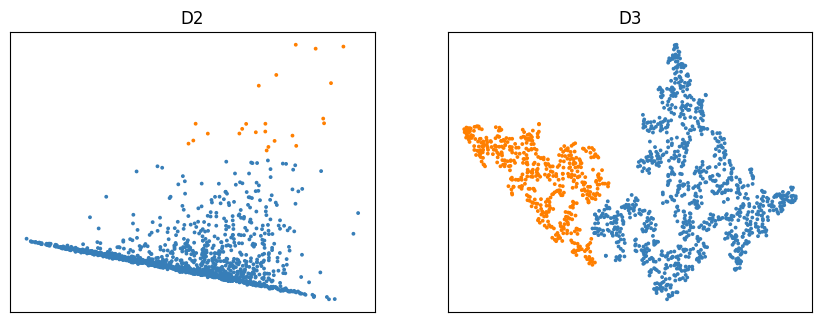

In [128]:
result_Birch1 = do_clustering(cluster_datasetD1, Birch(n_clusters=2))
result_Birch23 = do_clustering(cluster_datasets, Birch(n_clusters=2))
visualize_clusters(cluster_datasets, result_Birch23)

In [129]:
print('Adjusted rand score:')
print('D1: ', adjusted_rand_score(y, result_Birch1[0]))
print('D2: ', adjusted_rand_score(y, result_Birch23[0]))
print('D3: ', adjusted_rand_score(y, result_Birch23[1]))

Adjusted rand score:
D1:  0.15241797456688588
D2:  -0.0040519140791042746
D3:  0.15363241714717046


In [130]:
h1, c1, v1 = homogeneity_completeness_v_measure(y, result_Birch1[0])
h2, c2, v2 = homogeneity_completeness_v_measure(y, result_Birch23[0])
h3, c3, v3 = homogeneity_completeness_v_measure(y, result_Birch23[1])
print('Homogenity:')
print('D1: ', h1)
print('D2: ', h2)
print('D3: ', h3)
print('Completeness:')
print('D1: ', c1)
print('D2: ', c2)
print('D3: ', c3)
print('V-measure:')
print('D1: ', v1)
print('D2: ', v2)
print('D3: ', v3)

Homogenity:
D1:  0.09877216885346858
D2:  0.011939929308278398
D3:  0.10532195393010757
Completeness:
D1:  0.1641817982471552
D2:  0.16216549436263772
D3:  0.18104069838252204
V-measure:
D1:  0.12334168202853978
D2:  0.022242208176026606
D3:  0.13317071860126461
